<a href="https://colab.research.google.com/github/juanlu29/juanlu29/blob/gp_aprendizaje/libreriaGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librerias importadas y constantes usadas

In [1]:
# Modulos y constantes

import numpy as np
import random
import scipy
import scipy.linalg
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import drive
import pandas as pd
drive.mount('/content/drive/')
%cd /content/drive/My\ Drive/datosContaminacionMadrid

pi = np.pi

# Hiperparámetros de los kernels
s = 1.2 # np.sqrt(1.08)
l = 1. # np.sqrt(0.3)
sigma_signal_sq = np.power(0.3,1) # desviación estándar del ruido usado para enmascarar la señal de entrenamiento

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/datosContaminacionMadrid


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Informacion sobre la particion del sistema y las realizaciones a realizar

In [3]:
n_r = 3 # numero de realizaciones del proceso gaussiano

#x = np.linspace(0.,98./7.,600)
x = np.linspace(0,10,200)

#x_train = np.arange(95)/float(7.)
x_train = np.linspace(0.1,9.7,40)
y_train = 1.1*np.sin(2.*x_train) + np.asarray([random.gauss(0.,sigma_signal_sq) for i in range(len(x_train))])
#y_train = [77.1,64.32,79.29,85.49,97.54,81.22,59.58,71.5,36.41,41.54,39.3,41.54,51.84,67.85,63.08,35.62,31.82,34.59,59.53,32.37,52.31,47.25,32.62,48.26,70.21,77.59,63.39,71.5,97.21,89.41,52.16,52.01,37.43,35.93,61.74,61.82,52.6,56.59,61.17,49.74,57.28,43.7,67.75,57.56,45.21,35.72,28.95,40.75,29.87,26.94,44.07,43.29,55.73,39.88,58.18,73.5,73.58,41.12,33.78,56.15,69.69,75.89,78.16,64.17,49.33,52.43,63.22,58.25,80.84,84.56,99.02,51.71,67.99,71.25,70.11,82.22,94.46,72.89,77.78,62.36,58.2,50.07,38.36,62.98,78.97,70.29,56.22,86.1,55.41,38.37,41.77,53.82,39.01,33.37,49.32]
#y_train = y_train - 50.*np.ones(len(y_train))

n_tp = len(x) # puntos para muestrear el fondo continuo para la desviacion estándar


La siguiente celda contiene informacion sobre el conjunto de puntos - objetivos sobre el que entrenar el proceso gausiano, así como una especificación a priori de la matriz de covarianzas

Valor de las derivadas respectos los parametros del logaritmo de la distribucion marginal de verosimilitud : [ 8.40733941e+34 -4.59751646e+34]
La probabilidad marginal de verosimilitud para este modelo es:  -36.40667606719518
El logaritmo de la probabilidad marginal de verosimilitud para este modelo es:  1.5444771220053432e-16


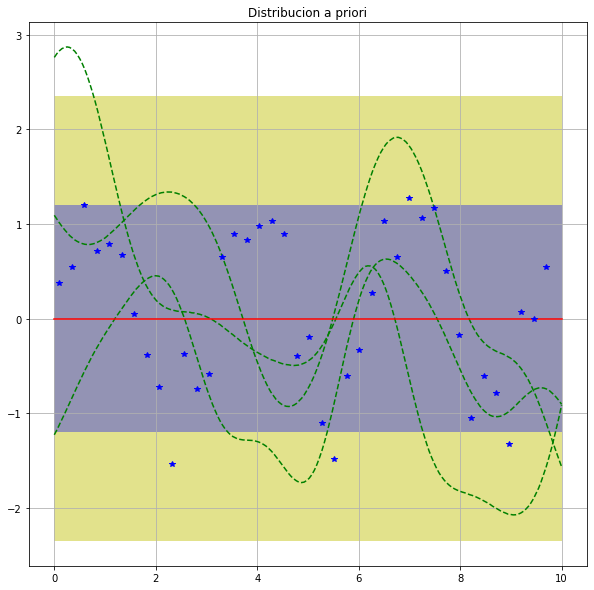

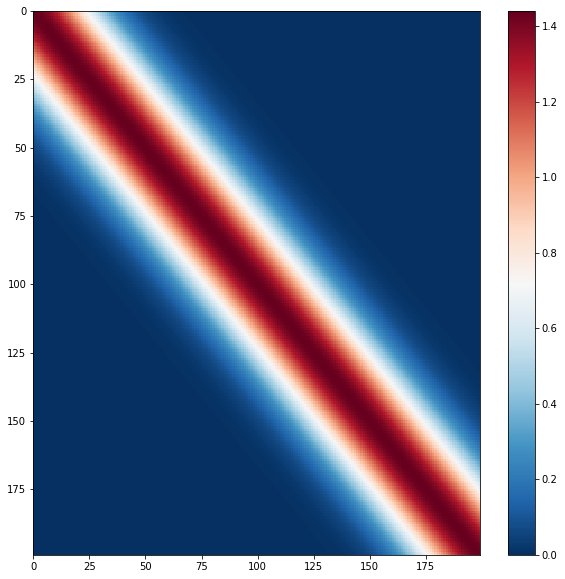

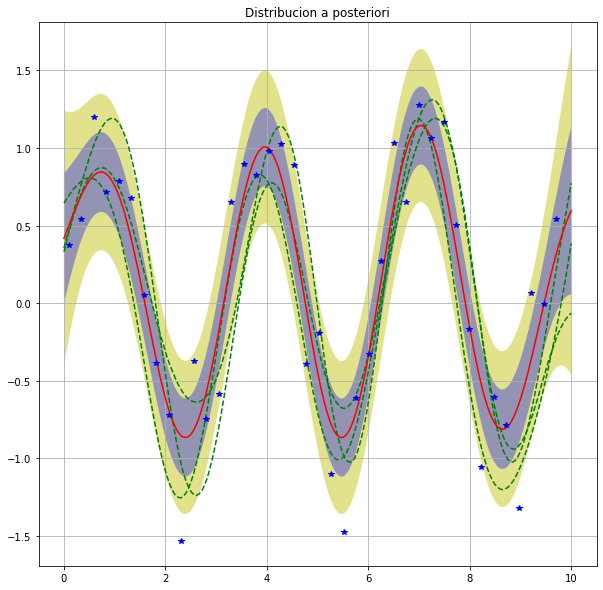

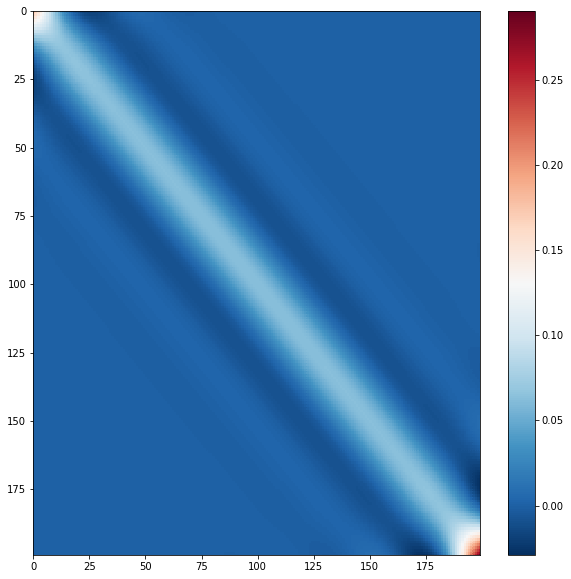

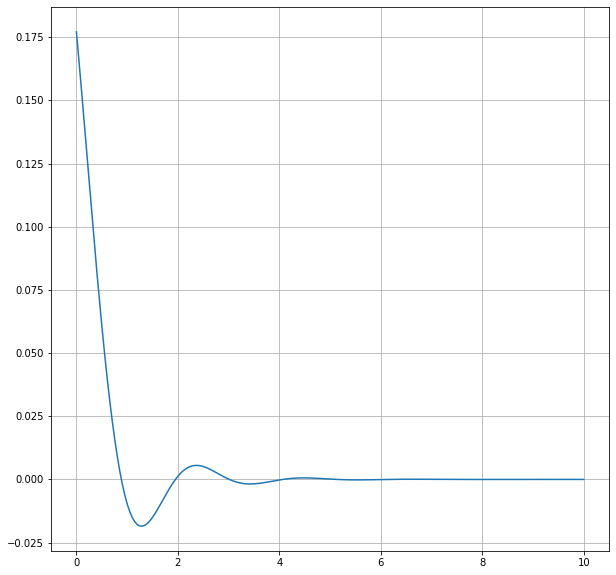

In [6]:

# Hacemos la proyeccion sobre el espacio propio del modelo de regresion linear y derivamos la matriz de dispersion de los parámetros
proyeccionlinear = espacioPropio()
aleatorio = espacioPropio()
corr_crec_dist = espacioPropio()
corr_kec = espacioPropio()
ou_kec = espacioPropio()
#mCov_x,phi_x,mean = proyeccionlinear.formaBilinealAleatoria(x,sigma_m_sq)
#mCov_train,phi_train,mean_train = proyeccionlinear.formaBilinealAleatoria(x_train,sigma_m_sq)

# Modelo lineal
#K_prior,K_train_prior,K_train_train,phi_x,phi_t,mean = proyeccionlinear.linear(x,x_train,sigma_b_sq,sigma_m_sq)
# Kernel aleatorio
#K_prior,K_train_prior,K_train_train,phi_x,phi_t,mean = aleatorio.covarianzaAleatoria(x,x_train,sigma_m_sq)
# Kernel correlaciones crecientes con distancia linealmente
#K_prior,K_train_prior,K_train_train,phi_x,phi_t,mean = corr_crec_dist.corr_linear_creciente(x,x_train,100.,2.)
# Kernel correlaciones decrecientes inversamente a la distancia
#K_prior,K_train_prior,K_train_train,phi_x,phi_t,mean = corr_crec_dist.corr_linear_decreciente(x,x_train,300.,500.)
# Kernel exponencial cuadratico
# Ahora nos devuelve tambien el valor de las derivadas
K_prior,K_train_prior,K_train_train, K_train_train_der_s, dummy1, dummy2, K_train_train_der_l, dummy3, dummy4, phi_x,phi_t,mean = corr_kec.kernel_exponencial_cuadratico(x,x_train,s,l)
# Kernel experimental OU
#K_prior,K_train_prior,K_train_train,phi_x,phi_t,mean = ou_kec.cov_drive(x,x_train,s,l)
# Kernel mater para nu semi enteros, evaluando en p = 0 (gp que muestrea OU)
#K_prior,K_train_prior,K_train_train,phi_x,phi_t,mean = ou_kec.maternCov_nu_halfIntegers(0,x, x_train,s,l)


# Generamos un proceso gausiano para generar la distribucion de funciones con probabilidades a priori (las que nos ofrece las incertidumbres en los parametros)
gp_cov_diag = gaussProcess(K_prior,K_train_prior,K_train_train,[K_train_train_der_s,K_train_train_der_l], np.zeros(n_tp),phi_x)
sigma_prior = gp_cov_diag.sigmaCalc(gp_cov_diag.K_prior)

# Entrenamos con los datos proyectados sobre el espacio propio de esta regresion
gp_cov_diag.entrenarGP(phi_t,y_train,sigma_signal_sq)
sigma_pred = gp_cov_diag.sigmaCalc(gp_cov_diag.K_pred)

# Calculamos valor de la derivada de la distribución marginal de verosimilitud al modelo con respecto a los hiperparámetros
gp_cov_diag.derivadaVerosimilitudMarginal()
print("Valor de las derivadas respectos los parametros del logaritmo de la distribucion marginal de verosimilitud :",gp_cov_diag.derVerMarg)


visualizacion_prior = datosVisualizacion("Distribucion a priori")
visualizacion_poste = datosVisualizacion("Distribucion a posteriori")

# Predictivo

visualizacion_poste.add_covariance(gp_cov_diag.K_pred)
visualizacion_poste.add_sigma(x,sigma_pred)
visualizacion_poste.add_mean(x,gp_cov_diag.mean_pred)
visualizacion_poste.add_train_data(x_train,y_train)

[visualizacion_poste.add_data(x,gp_cov_diag.distribucionGP(gp_cov_diag.mean_pred,gp_cov_diag.L_pred),inset) for inset in range(n_r) ]
[visualizacion_poste.add_data_plot(inset) for inset in range(n_r) ]

# Prior

visualizacion_prior.add_covariance(gp_cov_diag.K_prior)
visualizacion_prior.add_sigma(x,sigma_prior)
visualizacion_prior.add_mean(x,np.zeros(n_tp))
visualizacion_prior.add_train_data(x_train,y_train)

[visualizacion_prior.add_data(x,gp_cov_diag.distribucionGP(gp_cov_diag.mean_prior,gp_cov_diag.L_prior),inset) for inset in range(n_r) ]
[visualizacion_prior.add_data_plot(inset) for inset in range(n_r) ] # Visualiza trayectorias obtenidas de la distribución a priori

visualizacion_prior.mostrarPlot() # Muestra incertidumbre de la distribución de trayectorias a priori
visualizacion_poste.mostrarPlot() # Muestra incertidumbre de la distribución de trayectorias a posteriori
visualizacion_prior.hmapCov()
visualizacion_poste.hmapCov() 

# Covarianza punto a punto
gp_cov_diag.correlacionPuntoPunto()
visualizacion_poste.add_corrPuntoPunto(gp_cov_diag.corrPP_pred, phi_x)
visualizacion_poste.plotCorrPuntoPunto([0])

print("La probabilidad marginal de verosimilitud para este modelo es: ",gp_cov_diag.log_marg_y)
print("El logaritmo de la probabilidad marginal de verosimilitud para este modelo es: ", np.exp(gp_cov_diag.log_marg_y))

Este google colab sera un espacio donde practicar conceptos básicos sobre procesos gausianos, en general desarrollar clases para reproducir los conceptos básicos de estos y practicar alguna regresión "de juguete". Muestrea funciones del espacio F:R¹



In [43]:
class espacioPropio():
  '''
  Esta clase define el espacio propio donde proyectamos y la matriz de covarianza resultante
  '''

  def maternCov_nu_halfIntegers(self,p,x, x_train,s,l):
    '''
    Expresión simplificada de la covarianza de matérn para el caso que nu sean semienteros

    s es factor de escala del kernel. Permite escalar las trayectorias a la amplitud de la señal
    '''

    x_domain = np.concatenate((x_train,x), axis =None)

    r  = np.asarray([ [np.abs(xi-xj) for xi in x_domain] for xj in x_domain])

    ni = np.arange(p+1) # i corre desde 0 hasta el valor de p mismo

    # Factor escalar de factoriales
    gammaQuo = np.math.factorial(p)/np.math.factorial(2*p)

    # El siguiente ndarray tiene dimensionalidad 3, porque estamos generando un array a partir de una lista de matrices
    summatoryArray = np.asarray([(np.math.factorial(p + i)/(np.math.factorial(i)*np.math.factorial(p-i)))*np.power((np.sqrt(8*(p+0.5)*r)/l),p-i) for i in ni ])
    summatory = np.sum( np.asarray(summatoryArray), axis = 0) # Axis 0 significa que solo suma corriendo el indice de la posicion cero en el array, en este caso tendriamos un array tridimensional (x,y,z) y 0 hace referencia a x

    # Termino exponencial de los elementos del array
    exponential = np.exp(-(np.sqrt(2.*(p+0.5))*r)/l)

    K_total = s*gammaQuo*(np.multiply(exponential,summatory)) # Al ser un kernel estacionario, podemos interpretarlo como la evaluacion de una función dependiente de la distancia entre puntos del input

    plt.imshow(K_total)

    K0, K1, K2 = self.submatrices(K_total, len(x_train),len(x_train))

    return K2, K1.T, K0, x, x_train, np.zeros(len(x))

  def cov_drive(self,x,x_train, sigma_b,sigma_m):
    '''
    Obtiene la matriz de covarianza de un directorio en google drive
    '''
    cov_df = pd.read_csv('K_OU_experimental.csv')
    K_total_x = cov_df.to_numpy()

    K_total = K_total_x[:,1:]
    K_total = np.array(K_total, dtype=float)

    K0, K1, K2 = self.submatrices(K_total, len(x_train),len(x_train))

    return K2, K1.T, K0, x, x_train, np.zeros(len(x))

  def linear(self,x,x_train, sigma_b,sigma_m):
    '''
    Se interpretan sigma_b y sigma_m como varianzas de distribuciones a priori gaussianas
    para la ordenada en origen y para la pendiente de nuestro modelo linear.
    x es el input
    '''
    phi_x = np.array([np.array([1,xe]) for xe in x])
    phi_t = np.array([np.array([1,xe]) for xe in x_train])
    eps = np.array([[sigma_b,0],[0,sigma_m]])
    K_prior = np.matmul(np.matmul(phi_x,eps),phi_x.T)
    K_pred_train = np.matmul(np.matmul(phi_x,eps),phi_t.T) # Es la matriz de covarianzas entre datos de la distribución a priori y el entrenamiento
    K_train_train = np.matmul(np.matmul(phi_t,eps),phi_t.T) # Es la matriz de covarianzas entre los datos de entrenamiento

    return K_prior,K_pred_train,K_train_train, phi_x, phi_t, np.zeros(x.size)

  def covarianzaProceso(self,phi_x,covM):
    '''
    Devuelve la matriz de covarianza correspondiente a distribucion de probabilidad a priori en base a la incertidumbre de los parametros de una regresion lineal .
    '''
    return np.matmul(np.matmul(phi_x,covM),phi_x.T)

  def covarianzaAleatoria(self,x, x_train,sigma):
    '''
    Genera matriz de covarianza con correlaciones aleatorias sobre el espacio en que realizamos el proceso gaussiano,
    generamos una matriz de la aplicacion aleatoria dada una distribucion normal Sigma ~ normal(0,1)

    Partimos de que a priori, sin condicionar resultados, si tenemos los puntos sobre los que samplear las funciones
    y los de entrenamiento, partimos de que la matriz de covarianza a priori total o global resulta de combinar las siguientes submatrices

                                                  ( M(n_star,n_star), M(n_star,n_train) 
    M(n_star + n_train, n_star + n_train) =    (                                          )
                                                  ( M(n,train,n_star), M(n_train,n_train)

    Que es generada recordando la siguiente propiedad de matrices definidas positivas simétricas

    Cov = M*M_t

    Simplemente debemos generar M y obtener la matriz de covarianza de la anterior forma y las submatrices de covarianza cuando queramos condicionar el procesos gausiano

    Creo que no importa el orden de las coordenadas porque estamos trabajando con algebra lineal (permutaciones de filas dejan la matriz con las mismas propiedades)

    '''

    phi_x = x
    phi_t = x_train(97,)
    sqrt_K_total = np.array([[random.gauss(0,0.1) for xi in np.concatenate((x, x_train), axis=None)] for xj in np.concatenate((x, x_train), axis=None)])

    K_total = np.matmul(sqrt_K_total,sqrt_K_total.T) # Definiendola así nos aseguramos que resulte una matriz definida positiva
   
    K_prior = K_total[:x.size,:x.size]
    K_pred_train = K_total[:x.size,x.size:]
    K_train_train = K_total[x.size:,x.size:]

    return K_prior,K_pred_train,K_train_train, phi_x, phi_t, np.zeros(x.size)



  def corr_linear_creciente(self,x, x_train,s,l):
    '''
    Genera matriz de covarianza con correlaciones que aumentan con la separación entre coordenadas
    sigma y l son hiperparámetros de este kernel
    '''

  
    phi_x = x
    phi_t = x_train

    x_domain = np.concatenate((x,x_train), axis =None)

    K_total =  np.array([[(s*np.abs(xj-xi))/l for xi in x_domain] for xj in x_domain]) # Debemos tomar valor absoluto para asegurarnos que la matriz resultante sea simétrica

    #K_total = np.matmul(sqrt_K_total,sqrt_K_total.T) # Definiendola así nos aseguramos que resulte una matriz definida positiva    

    K0, K1, K2 = self.submatrices(K_total, x.size, x_train.size)

    return K0, K1, K2, phi_x, phi_t, np.zeros(x.size)

  def corr_linear_decreciente(self,x, x_train,s,l):
    '''
    Genera matriz de covarianza con correlaciones que disminuyen con la separación entre coordenadas
    sigma y l son hiperparámetros de este kernel

    cor(dx) =   s. / (1 + dx/l)

    '''

  
    phi_x = x
    phi_t = x_train

    x_domain = np.concatenate((x,x_train), axis =None)

    K_total =  np.array([[s/(1.+(np.abs(xj-xi)/l)) for xi in x_domain] for xj in x_domain]) # Debemos tomar valor absoluto para asegurarnos que la matriz resultante sea simétrica

    #K_total = np.matmul(sqrt_K_total,sqrt_K_total.T) # Definiendola así nos aseguramos que resulte una matriz definida positiva    

    K0, K1, K2 = self.submatrices(K_total, len(x), len(x_train))

    return K0, K1, K2, phi_x, phi_t, np.zeros(len(x))


  def kernel_exponencial_cuadratico(self,x, x_train,s,l):
    '''
    Genera matriz de covarianza con correlaciones de acuerdo al kernel exponencial cuadrático

    K(x-x') =   s² exp((-[x-x']²)/2l²)

    '''

    x_domain = np.concatenate((x_train,x), axis =None)

    K_total =  np.array([[np.power(s,2)*np.exp(-np.power(xi-xj,2)/(2.*np.power(l,2)))  for xi in x_domain] for xj in x_domain]) # Debemos tomar valor absoluto para asegurarnos que la matriz resultante sea simétrica


    # Se calculan derivadas parciales respecto los hiperparámetros del modelo

    #s
    K_total_part_d_s = np.array([[2.*s*np.exp(-np.power(xi-xj,2)/(2.*np.power(l,2)))  for xi in x_domain] for xj in x_domain]) 
    
    #l
    K_total_part_d_l = np.array([[-(np.power(xi-xj,2)/np.power(l,3))*np.power(s,2)*np.exp(-np.power(xi-xj,2)/(2.*np.power(l,2)))  for xi in x_domain] for xj in x_domain]) 


    K0, K1, K2 = self.submatrices(K_total, len(x_train),len(x_train))

    K_p_s_0, K_p_s_1, K_p_s_2 = self.submatrices(K_total_part_d_s, len(x_train),len(x_train))
    K_p_l_0, K_p_l_1, K_p_l_2 = self.submatrices(K_total_part_d_l, len(x_train),len(x_train))


    return K2, K1.T, K0,  K_p_s_0, K_p_s_1, K_p_s_2, K_p_l_0, K_p_l_1, K_p_l_2, x, x_train, np.zeros(len(x))

  def submatrices(self,K_total,i,f):
    '''
    Este metodo, dada una matriz de covarianzas del proceso gausiano sin condicionar a las observaciones,
    devuelve las matrices K_prior, K_pred_train, K_train_train que serán usadas para muestrear el proceso

    Solo sirve si el dominio de prueba y el de entrenamiento estan concatenados secuencialmente (no mezclados u ordenados de otra manera los puntos)
    '''
    Ks = [K_total[:i,:i], K_total[:i,i:], K_total[i:,i:]]
    return Ks[0], Ks[1], Ks[2] #  K_train_train, K_train_pred, K_pred_pred o K_prior prior respectivamente



class gaussProcess():
  def __init__(self,K_p,K_p_t,K_t_t,prior_Partial_Der,Mean, Input):
    '''
    Los objetos de esta clase modelan procesos gaussianos caracterizados por su promedio y covarianza
    Eps es la matriz de covarianzas de los pesos del proceso gausiano
    prior_Partial_der corresponde a una lista de matrices de la distribución a priori correspondientes a su derivada respecto los distintos parámetros
    '''
    self.x = Input # Dominio de la regresion
    self.K_prior = K_p # Matriz de covarianzas usada para definir la distribucion a priori y mas tarde para muestrear funciones del proceso gausiano
    self.K_pred_train = K_p_t # Es la matriz de covarianzas entre datos de la distribución a priori y el entrenamiento
    self.K_train_train = K_t_t # Es la matriz de covarianzas entre los datos de entrenamiento
    self.mean_prior = Mean
    self.Derivadas = prior_Partial_Der
    self.L_prior = self.cholDescomp(self.K_prior)

  def cholDescomp(self,K):
    '''
    Cholesky decomposition
    '''
    try:
      L = scipy.linalg.cholesky(K, lower=True)
    except:
      L = scipy.linalg.cholesky(K + np.diag(0.000001*np.ones(int(np.sqrt(K.size)))), lower=True)

    return L

  def calcInvK_prior(self):
    '''
    Calculo de la inversa de la matriz de covarianza de la distribución a priori con ruido usando de la libreria de numpy, su paquete de algebra lineal linalg.
    '''
    # Calculo de matriz inversa de la covarianza. 
    try:
      self.invK = np.linalg.inv(self.K_train_train)
    except:
      print("La matriz inversa no existe porque el determinante es cero")



  def entrenarGP(self,entrenamiento_x,entrenamiento_y,noiseLevel):
    '''
    Dadas unas observaciones junto a sus valores en el dominio de los procesos, obtiene la distribución condicionada a las trayectorias asociadas a dichas medidas.
    También calcula el logaritmo de la probabilidad de verosimilitud marginal (marginal likelihood) de las observaciones dados los inputs 
    y parámetros del modelo usado.

    Este algoritmo esta especificado en el libro "Gaussian Processes for Machine Learning", como algoritmo 2.1
    '''
    self.xtrain = entrenamiento_x
    self.ytrain = entrenamiento_y
    self.n_train = len(entrenamiento_x)

    # Definimos nueva covarianza
    # Primero se realiza la descomposición cholesky de la adición de la covarianza de la distribución a priorir y el término de ruido.
    cholL = np.linalg.cholesky(self.K_train_train + noiseLevel*np.diag(np.ones(len(self.xtrain))))

    # Calculo del vector alfa como solucion del sistema K*alfa = y_entrenamiento usando la descomposición cholesky anterior
    alfa = scipy.linalg.cho_solve((cholL,True),self.ytrain)

    # La media predictiva dados los datos
    self.mean_pred = np.matmul(self.K_pred_train,alfa)

    # Vector v solución particular del sistema cholL*v = k_star para todos los datos del entrenamiento.
    # Este sistema se resuelve introduciendo k_star no como matriz columna sino como la submatriz calculada como la evaluación de la covarianza a priori de los inputs de los valores a predecir y los inputs del entrenamiento
    v = scipy.linalg.solve_triangular(cholL,self.K_pred_train.T, lower=True)

    # Covarianza predictiva. El proceso llevado a cabo ha sido obtener la distribución condicionada del GP (inputs predictivos) a las observaciones y_entrenamiento
    self.K_pred = self.K_prior - np.matmul(v.T,v)

    # Calculo de la probabilidad de verosimilitud marginal a este modelo y sus parámetros
    self.log_marg_y = -np.sum(np.log(np.diag(cholL)),axis=0)
    self.log_marg_y = self.log_marg_y - 0.5*np.dot(alfa,self.ytrain)
    self.log_marg_y = self.log_marg_y - (float(self.n_train/2.))*np.log(2*pi)


    # Valor importante para muestrear procesos gausianos.
    self.L_pred = self.cholDescomp(self.K_pred)


  def distribucionGP(self,mean,L):
    '''
    Genera realizaciones del proceso gaussiano dada la descomposicion cholesky de la matriz de covarianzas y la media correspondiente
    '''
    gaussNumbers = np.fromiter([ random.gauss(0,1) for x in range(len(np.diag(L))) ],float)
    return mean + np.matmul(L,gaussNumbers.T)

  def sigmaCalc(self,cov):
    '''
    Desviacion estándar punto a punto del proceso gausiano dado por la matriz de covarianza 
    Es la raiz cuadrado de los elementos de la diagonal de la matriz de covarianzas del proceso generado
    '''
    return np.sqrt(np.diag(cov))


  def correlacionPuntoPunto(self):
    '''
    Obtiene la correlacion punto a punto dado un inputo concreto por el indice i_x
    '''
    try:
      self.corrPP_pred = np.array([ self.K_pred[i,:] for i in range(len(self.K_pred)) ])
    except:
      print(" Proceso gaussiano no entrenado aún, no existe K_pred ")
    self.corrPP_prior = np.array([ self.K_prior[i,:] for i in range(len(self.K_prior)) ])

  def derivadaVerosimilitudMarginal(self,*args):
    '''
    Dadas unas observaciones particulares estima la derivada del logaritmo de la probabilidad asociada a la distribución de verosimilitud marginal asociada al modelo respecto sus hiperparámetros
    '''

    if not isinstance(args[0], np.ndarray):
      raise NameError("Las observaciones dadas para calcular la derivada del logaritmo de la distribución marginal de verosimilitud no es un array con datos")
    else:
      observaciones = args[0]

    # Vector auxiliar alpha
    try:
      print("inversa", self.invK)
      alpha = np.matmul(self.invK,observaciones)
      print("alfa", alpha)
      print("alpha_T", alpha.T)
    except:
      raise NameError("Necesitas calcular la matriz inversa de covarianzas de la distribución a priori")

    alpha_alpha = np.matmul(alpha,alpha.T)
    print("valor alpha_alpha", alpha_alpha)
    alpha_alpha_minus_invK = alpha_alpha - self.invK
    print(np.shape(alpha_alpha_minus_invK),np.shape(alpha_alpha),np.shape(self.invK))

    # Calculo. Es el valor de la derivada del logaritmo
    self.derVerMarg = np.asarray([ 0.5*np.trace(np.matmul(alpha_alpha_minus_invK,self.Derivadas[i])) for i in range(len(self.Derivadas))])
  
  def derivada_LO_CV(self,*args):
    '''
    Dadas unas observaciones particulares estima la derivada de la suma de los logaritmos de la evaluación de la distribución de probabilidad marginal de verosimilitud a que subconjuntos
    de las observaciones están condicionadas al resto, respecto a los hiperparámetros del modelo. Si se encuentra el máximo de este valor, estamos asegurándonos de que con los hiperparámetros ajustados
    las "predicciones" tras generar trayectorias del proceso gausiano que corresponderían a los subconjuntos excluidos sucesivamente son las más probables que el modelo puede hacer. Al ser la suma, esta optimización 
    es global y abarca la aproximación de observacion/test de todos los subconjuntos.
    '''

    if not isinstance(args[0], np.ndarray):
      raise NameError("Las observaciones dadas para calcular la derivada del logaritmo de la distribución marginal de verosimilitud no es un array con datos")
    else:
      observaciones = args[0]

    # Vector auxiliar alpha y matriz auxiliar Z y la diagonal de la inversa de la distribucion a priori
    try:
      alpha = np.matmul(self.invK,observaciones)
      invK_diag = np.diag(self.invK)
      zeta = [np.matmul(self.invK,self.Derivadas[i]) for i in range(len(self.Derivadas)) ] # Es una lista de matrices
      zeta_K = [np.diag(np.matmul(zeta[i],self.invK)) for i in range(len(self.Derivadas)) ]
      alpha_invK = np.multiply(alpha,1./invK_diag)
    except:
      raise NameError("Necesitas calcular la matriz inversa de covarianzas de la distribución a priori")
    
    termino_1 = [np.matmul(np.matmul(alpha_invK,zeta[i]),alpha) for i in range(len(self.Derivadas)) ] # Debido a Z esto es una lista
    termino_2 = [np.sum(np.multiply(np.multiply(0.5*(1. + np.multiply(np.power(alpha,2),1./invK_diag)),zeta_K[i]),1./invK_diag)) for i in range(len(self.Derivadas)) ] # Debido a zeta_K esto es una lista

    # Calculo. Es el valor de la derivada del logaritmo
    self.derVerLOO = np.asarray([ termino_1[i] + termino_2[i] for i in range(len(self.Derivadas))])
    

class datosVisualizacion():
  '''
  Esta clase contiene los datos de entrenamiento y realizaciones de los procesos gaussianos para la visualización de los mismos
  '''
  def __init__(self,Titulo):
    self.x = []
    self.y = []
    self.sigma = []
    self.realizacion_dict = {}
    self.titulo = Titulo
    self.inicializacionPlot()

  def inicializacionPlot(self):
    '''
    Inicializa el objeto matplotlib
    '''
    self.fig,self.ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    self.ax.set_title(self.titulo)
    self.fig_hm, self.ax_hm = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

  def add_covariance(self, cov):
    '''
    Añada matriz de covarianza y alternativamente calcula la covarianza del proceso gaussiano sobre el dominio
    '''

    self.cov_GP = cov

  def add_mean(self,X,Mean):
    '''
    Almacena la desviación estándar de un proceso gausiano dado
    '''
    self.x_mean = X
    self.mean = Mean


  def add_sigma(self,X,Sigma):
    '''
    Almacena la desviación estándar de un proceso gausiano dado
    '''
    self.x_sigma = X
    self.sigma = Sigma
    self.meanMarker = 'r-'

  def add_train_data(self,X,Y):
    self.xtrain = X
    self.ytrain = Y
    self.marker = 'b*'

  def add_data(self,X,Y,label):
    self.x.append(X)
    self.y.append(Y)
    self.realizacion_dict[label] = len(self.x)-1

  def add_corrPuntoPunto(self,corrPP, corrInputs):
    '''
    Añade correlaciones punto a punto sobre un dominio dado por los valores corrInputs
    '''
    self.corrPP = corrPP
    self.corr_in = corrInputs

  def add_data_plot(self,label):
    try:
      self.ax.plot(self.x[self.realizacion_dict[label]],self.y[self.realizacion_dict[label]],'g--')
    except:
      print('No existe datos referentes a etiqueta :',label)

  def add_train_data_plot(self):
    try:
      self.ax.plot(self.xtrain,self.ytrain,self.marker)
    except:
      print('No existen datos de entrenamiento')

  def add_mean_plot(self):
    try:
      self.ax.plot(self.x_mean,self.mean,self.meanMarker)
    except:
      print('No existen datos de entrenamiento')



  def contorno_sigma(self):
    '''
    Muestra en pantalla contorno de 1 y 2 veces los valores de sigma del proceso gausiano
    '''
    self.ax.fill(np.concatenate((self.x_sigma,self.x_sigma[::-1])),
             np.concatenate((self.mean - 1.9600 * self.sigma,
                             (self.mean + 1.9600 * self.sigma)[::-1])),
             alpha=.45, fc='y', ec='None', label='95% confidence interval')
    self.ax.fill(np.concatenate((self.x_sigma,self.x_sigma[::-1])),
             np.concatenate((self.mean - 1.000 * self.sigma,
                             (self.mean + 1.000 * self.sigma)[::-1])),
             alpha=.35, fc='b', ec='None', label='68% confidence interval')
    
  def plotCorrPuntoPunto(self,indices):
    '''
    Visualiza correlaciones punto a punto para los inputs dados por sus indices en la lista indices como argumento del metodo
    '''

    xx = [ self.corr_in for i in indices ]
    ' Generamos y visualizamos las imagen directamente en este metodo'
    self.fig_cpp, self.ax_cpp = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    try:
      [self.ax_cpp.plot(self.corr_in,self.corrPP[indice],'-') for indice in indices] 
    except:
      print('No existe datos referentes referentes a correlaciones punto a punto')
    self.ax_cpp.grid(True)
    self.fig_cpp.show()



  def mostrarPlot(self):
    '''
    Muestra plot
    '''
    self.add_mean_plot()
    self.add_train_data_plot()
    self.contorno_sigma()
    self.ax.grid(True)
    self.fig.show()

  def hmapCov(self):
    '''
    Visualiza covarianza como campo bidimensional
    '''
    plotRange = np.arange(len(self.cov_GP))
    heatmap = self.ax_hm.pcolormesh(self.cov_GP,cmap='RdBu_r')
    self.ax_hm.axis([plotRange.min(), plotRange.max(), plotRange.max(), plotRange.min()])
    self.fig_hm.colorbar(heatmap, ax=self.ax_hm)
    self.fig_hm.show()




In [41]:
n_r = 4

parametros = np.array([[1.,1.,1.],[2.,2.,1.],[1.,1.,0.75],[2.,2.,0.75],[1.,1.,3.],[2.,2.,3.]])

x = np.linspace(0.,5.,500)

xt = np.array([1.,2.,4.])
yt = np.array([1.,2.,1.8])


# Generacion de kernels
realizaciones = [ espacioPropio() for i in range(len(parametros)) ]
matricesCov = [ realizaciones[i].kernel_exponencial_cuadratico(x,xt,parametros[i][1],parametros[i][2]) for i in range(len(parametros)) ]

# Generamos procesos gausianos
gps = [gaussProcess(matricesCov[i][0],matricesCov[i][1],matricesCov[i][2],matricesCov[i][5],matricesCov[i][3])  for i in range(len(parametros)) ]
sigmas_prior = [gp.sigmaCalc(gp.K_prior) for gp in gps ]

# Entrenamos con los datos proyectados sobre el espacio propio del kernel
[ gps[i].entrenarGP(xt,yt,parametros[i][0]) for i in range(len(parametros)) ]
sigmas_pred = [ gp.sigmaCalc(gp.K_pred) for gp in gps ]

# Predictivo

visualizaciones_poste = [  datosVisualizacion("Distribucion a posteriori")  for i in range(len(parametros)) ]

[ visualizaciones_poste[i].add_covariance(gps[i].K_pred)  for i in range(len(parametros)) ]
[ visualizaciones_poste[i].add_sigma(x,sigmas_pred[i])  for i in range(len(parametros)) ]
[ visualizaciones_poste[i].add_mean(x,gps[i].mean_pred)  for i in range(len(parametros)) ]
[ visualizaciones_poste[i].add_train_data(xt,yt)  for i in range(len(parametros)) ]

[ [ visualizaciones_poste[i].add_data(x,gps[i].distribucionGP(gps[i].mean_pred,gps[i].L_pred)[0],inset) for inset in range(n_r) ] for i in range(len(parametros))  ]
[ [ visualizaciones_poste[i].add_data_plot(inset) for inset in range(n_r) ] for i in range(len(parametros)) ]


# Prior
 
visualizaciones_prior = [ datosVisualizacion("Distribucion a priori")  for i in range(len(parametros)) ]

[ visualizaciones_prior[i].add_covariance(gps[i].K_prior)  for i in range(len(parametros)) ]
[ visualizaciones_prior[i].add_sigma(x,sigmas_prior[i] )  for i in range(len(parametros)) ]
[ visualizaciones_prior[i].add_mean(x,gps[i].mean_prior)  for i in range(len(parametros)) ]
[ visualizaciones_prior[i].add_train_data(xt,yt)  for i in range(len(parametros)) ]

[ [ visualizaciones_prior[i].add_data(x,gps[i].distribucionGP(gps[i].mean_prior,gps[i].L_prior)[0],inset) for inset in range(n_r) ] for i in range(len(parametros))  ]
[ [ visualizaciones_prior[i].add_data_plot(inset) for inset in range(n_r) ] for i in range(len(parametros)) ]

[ vis.mostrarPlot() for vis in visualizaciones_poste ]
[ vis.hmapCov()  for vis in visualizaciones_poste ]
[ vis.mostrarPlot()  for vis in visualizaciones_prior ]
[ vis.hmapCov() for vis in visualizaciones_prior ]


KeyboardInterrupt: ignored

Jugamos con la derivada respecto los parametros de la distribucióón marginal de verosimilitud de las observaciones respecto al modelo

In [44]:
grp = 5
ss = np.linspace(0.1,2.,grp)
ls = np.linspace(0.1,3.,grp)

valores_s = np.zeros((grp,grp))
valores_l = np.zeros((grp,grp))
probabilidades = np.zeros((grp,grp))


i = 0
for s in ss:

  j = 0
  for l in ls:
    # Ahora nos devuelve tambien el valor de las derivadas
    K_prior,K_train_prior,K_train_train, K_train_train_der_s, dummy1, dummy2, K_train_train_der_l, dummy3, dummy4,  phi_x,phi_t,mean = corr_kec.kernel_exponencial_cuadratico(x,x_train,s,l)
    print(K_train_train_der_l)
    print(K_train_train_der_s)

    # Generamos un proceso gausiano para generar la distribucion de funciones con probabilidades a priori (las que nos ofrece las incertidumbres en los parametros)
    gp_cov_diag = gaussProcess(K_prior,K_train_prior,K_train_train,[K_train_train_der_s,K_train_train_der_l], np.zeros(n_tp),phi_x)

    print("Derivadas del gp")
    print(gp_cov_diag.Derivadas[0])
    print(gp_cov_diag.Derivadas[1])

    # Calculamos valor de la derivada de la distribución marginal de verosimilitud al modelo con respecto a los hiperparámetros

    # Necesitamos calcular la matriz inversa de la covarianza de la distribucion a prior
    gp_cov_diag.calcInvK_prior()
    gp_cov_diag.derivadaVerosimilitudMarginal(y_train)
    print("s :", s)
    print("l :", l)
    print("Derivadas respecto hiperparámetros :",gp_cov_diag.derVerMarg)
    valores_s[i,j] = gp_cov_diag.derVerMarg[0]
    valores_l[i,j] = gp_cov_diag.derVerMarg[1]
    #probabilidades[i,j] = gp_cov_diag.log_marg_y
  
    j = j + 1
  
  i = i + 1

fig_1, ax_1 = plt.subplots(1,1)
fig_2, ax_2 = plt.subplots(1,1)
#fig_3, ax_3 = plt.subplots(1,1)

ax_1.imshow(valores_s)

ax_2.imshow(valores_l)


#ax_3.imshow(probabilidades)

fig_1.show()
fig_2.show()
#fig_3.show()


[[-0.00000000e+00 -2.92874026e-02 -1.32295071e-05 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-2.92874026e-02 -0.00000000e+00 -2.92874026e-02 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-1.32295071e-05 -2.92874026e-02 -0.00000000e+00 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 ...
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
  -2.92874026e-02 -1.32295071e-05]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -2.92874026e-02
  -0.00000000e+00 -2.92874026e-02]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -1.32295071e-05
  -2.92874026e-02 -0.00000000e+00]]
[[2.00000000e-01 9.66713093e-03 1.09169272e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.66713093e-03 2.00000000e-01 9.66713093e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.09169272e-06 9.66713093e-03 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.00000000e

KeyboardInterrupt: ignored